In [137]:
import numpy as np
import pandas as pd
from numpy.random import normal as norm
from matplotlib import pyplot as plt
import random
import pickle
from fairsearchdeltr import Deltr
from tqdm.notebook import tqdm

In [138]:
# for better simulations (be careful: 200 times longer)

# fixed biases [d-color, d-shape]
# -0.5 => green are perceived of having higher quality
# 1.5 => stars are perceived of having lower quality
d = [-0.5, 1.5]

# there are equal number of stars and circles i.e. N
# out of which f * N are green circles and (1 - f) * N are orange circles
# out of which f * N are orange stars and (1 - f) * N are green stars
# [f, (1 - f)]
f = [0.2, 0.8]

In [139]:
# Genetare biased distribution
# real quality q0 is from N(0, 1)
# d - discrimination against 1s
# f - fraction of indviduals having property having hidden (second) property
# N - number of people

def generate(d = [0.5, 0.5], f = [0.5, 0.5], N = [2000, 2000]):
    # size of groups
    s = [(1 - f[0]) * N[0], f[0] * N[0], (1 - f[1]) * N[1], f[1] * N[1]]
    s = [int(x) for x in s]

    # vector of properties
    a = [(0,0)] * s[0] + [(0,1)] * s[1] + [(1,0)] * s[2] + [(1,1)] * s[3]

    m = 0
    st = 1
    q0 = norm(m, st, len(a))

    # creating bias
    bias = [0 for i in range(s[0])] + [-d[1] * st for i in range(s[1])] + [-d[0] * st for i in range(s[2])] + [-d[1] * st - d[0] * st for i in range(s[3])]
    q = q0 + bias

    # shuffling the results
    rnd = [x for x in range(len(a))]
    random.shuffle(rnd)

    q = [q[i] for i in rnd]
    a = [a[i] for i in rnd]
    q0 = [q0[i] for i in rnd]

    # return vectors of properties, perceived qualities and real qualities
    return a, q, q0

def conv_to_df(a, q):
    data = list(zip(list(list(zip(*a))[0]), list(list(zip(*a))[1]), q))
    df = pd.DataFrame(data, columns=['color', 'shape', 'perceived_quality'])
    df['q_id'] = 1
    df['doc_id'] = pd.Series(range(df.shape[0]))
    df['judgement'] = (df['perceived_quality'] - df['perceived_quality'].min()) / \
                  (df['perceived_quality'].max() - df['perceived_quality'].min())

    return df[['q_id', 'doc_id', 'color', 'shape', 'perceived_quality', 'judgement']]

In [140]:
# setup the DELTR object
protected_feature = "color"  # column name of the protected attribute (index after query and document id)
gamma = 1200  # value of the gamma parameter
number_of_iterations = 5  # number of iterations the training should run
standardize = True  # let's apply standardization to the features

# create the Deltr object
dtr = Deltr(protected_feature, gamma, number_of_iterations, standardize=standardize)

In [141]:
epoch = 10

for i in tqdm(range(epoch)):
    a, q, q0 = generate(d, f)
    df = conv_to_df(a, q)
    df_without_shape = df[['q_id', 'doc_id', 'color', 'perceived_quality', 'judgement']]
    dtr.train(df_without_shape)

  0%|          | 0/10 [00:00<?, ?it/s]

.
.
.
.
.
.
.
.
.
.


In [142]:
with open('dltr_synth_obj', 'wb') as obj_file:
    pickle.dump(dtr, obj_file)

In [143]:
dltr_saved: Deltr = None

with open('dltr_synth_obj', 'rb') as obj_file:
    dltr_saved = pickle.load(obj_file)

print(dltr_saved.log)

[<TrainStep [1643312204402,[-0.00018961  0.08066612],[[ 0.00133309 -0.01775387]
 [ 0.00133309 -0.01775387]
 [ 0.00133309 -0.01775387]
 ...
 [ 0.00133309 -0.01775387]
 [ 0.00133309 -0.01775387]
 [ 0.00133309 -0.01775387]],3998.3118719908007,0.0]>, <TrainStep [1643312217970,[0.06843088 0.08215009],[[-0.01715941 -0.00037109]
 [-0.01715941 -0.00037109]
 [-0.01715941 -0.00037109]
 ...
 [-0.01715941 -0.00037109]
 [-0.01715941 -0.00037109]
 [-0.01715941 -0.00037109]],3994.8599724096316,0.04120534548470603]>, <TrainStep [1643312232589,[0.05854358 0.10981563],[[ 0.00247244 -0.00691811]
 [ 0.00247244 -0.00691811]
 [ 0.00247244 -0.00691811]
 ...
 [ 0.00247244 -0.00691811]
 [ 0.00247244 -0.00691811]
 [ 0.00247244 -0.00691811]],3995.2167142803946,0.0]>, <TrainStep [1643312246916,[0.05101321 0.119463  ],[[ 0.00188306 -0.00241245]
 [ 0.00188306 -0.00241245]
 [ 0.00188306 -0.00241245]
 ...
 [ 0.00188306 -0.00241245]
 [ 0.00188306 -0.00241245]
 [ 0.00188306 -0.00241245]],3994.6144345651333,0.0]>, <Trai

In [144]:
rnk_w_s = dltr_saved.rank(df_without_shape[['q_id', 'doc_id', 'color', 'perceived_quality']])
rnk_w_s.head(5)

doc_id  color  judgement
1443    1443      1   0.509334
2039    2039      1   0.457230
2279    2279      1   0.428102
893      893      0   0.415832
3749    3749      1   0.414863

In [145]:
# return individuals with top percieved qualities
def getTop(a, q, top = 0.1):
    df = conv_to_df(a, q).sort_values(['perceived_quality'], ascending=[0])
    items = df[:int(df.shape[0] * top)]
    result = [(item['perceived_quality'], (int(item['color']), int(item['shape']))) for index, item in items.iterrows()]
    return result

In [146]:
def getTopDebiased(a, q, top = 0.1):
    df = conv_to_df(a, q)[['q_id', 'doc_id', 'color', 'shape', 'perceived_quality']]
    items = dltr_saved.rank(df[['q_id', 'doc_id', 'color', 'perceived_quality']])[:int(df.shape[0] * top)]
    result = [(df.loc[index]['perceived_quality'], (int(df.loc[index]['color']), int(df.loc[index]['shape']))) for index, _ in items.iterrows()]
    return result

In [161]:
# Compute chances to be in top k% for aggregated groups before and after debiasing
# d => fixed biases []
# f => number of elements
def get_aggregated(d, f, Nsim, k_range, with_shape):
    results = {'original': {0: [], 1: []},
               'debiased': {0: [], 1: []}}


    # shapes(invisible) => 0: circle; 1: stars
    # colors(visible) => 0: orange; 1: green
    groups = [0, 1]

    for k in k_range:
        simulations = {'original': {0: [], 1: []},
                       'debiased': {0: [], 1: []}}

        for i in tqdm(range(0, Nsim), desc='Simulations for Top {}'.format(k*100)):
            # properties, perceived qualities and real qualities
            a, q, q0 = generate(d, f, [1000, 1000])
            for group in groups:
                # compute expected chances to be in top
                exp = len([x for x in a if x[0] == group]) / len(q)

                for approach in ['original', 'debiased']:
                    if approach == 'original':
                       top = getTop(a, q, k)
                    else:
                       top = getTopDebiased(a, q, k)

                    # compute real chances to be in top
                    real = len([x for x in top if x[1][0] == group]) / len(top)
                    simulations[approach][group].append((real - exp) / exp)

        for group in [0, 1]:
            for approach in ['original', 'debiased']:
                results[approach][group].append(np.mean(simulations[approach][group]))
    return results

In [162]:
def plot_aggregated(results):
    colors = ['orange', 'green']
    styles = {'original': '-', 'debiased': '--'}
    for approach in ['original', 'debiased']:
        for group in [0, 1]:
            plt.plot(k_range, results[approach][group], color = colors[group], ls = styles[approach])

    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

In [163]:
# for quick results
Nsim = 5

# to fetch top k% candidates
k_range = [i / 100 for i in range(1, 101, 5)]

Simulations for Top 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

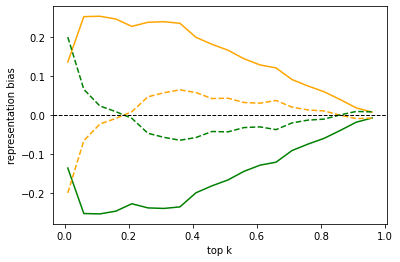

In [164]:
results_agg = get_aggregated(d, f, Nsim, k_range, False)
plot_aggregated(results_agg)

In [165]:
# Compute chances to be in top k% for disaggregated groups before and after debiasing
def get_disaggregated(d, f, Nsim, k_range):
    groups = [(0,0),(0,1),(1,0),(1,1)]

    results = {'original': {g:[] for g in groups},
               'debiased': {g:[] for g in groups}}

    for k in k_range:
        simulations = {'original': {g:[] for g in groups},
                       'debiased': {g:[] for g in groups}}

        for i in tqdm(range(0, Nsim), desc='Simulations for Top {}'.format(k*100)):
            a, q, q0 = generate(d, f, [200, 200])

            for g in groups:
                # compute expected chances to be in top
                exp = len([x for x in a if x == g]) / len(q)

                for approach in ['original', 'debiased']:
                    if approach == 'original':
                       top = getTop(a, q, k)
                    else:
                       top = getTopDebiased(a, q, k)
                    # compute real chances to be in top
                    real = len([x for x in top if x[1] == g]) / len(top)
                    simulations[approach][g].append((real - exp) / exp)

        for g in groups:
            for approach in ['original', 'debiased']:
                results[approach][g].append(np.mean(simulations[approach][g]))
    return results

def plot_disaggregated(results):
    groups = [(0,0),(0,1),(1,0),(1,1)]
    fill = {'original': 'full', 'debiased': 'none'}
    colors = ['orange', 'green']
    shapes = ['o', '*']
    #ms = [6, 9, 6, 9]
    # plt.figure(figsize=(15,10))
    for g in groups:
        for approach in ['original', 'debiased']:
            plt.plot(k_range, results[approach][g], shapes[g[1]], color = colors[g[0]], lw = 2, fillstyle = fill[approach])

    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.fill_between(k_range, results['debiased'][(0,1)], results['original'][(0,1)], color='orange', alpha=.25)

    plt.xlabel('top k')
    plt.ylabel('representation bias')

Simulations for Top 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

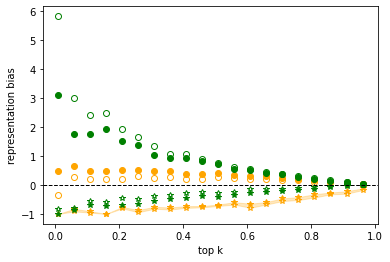

In [166]:
results_dis_agg = get_disaggregated(d, f, Nsim, k_range)
plot_disaggregated(results_dis_agg)

In [167]:
np.save('results_deltr_synth.npy', {'agg': results_agg, 'diss_agg': results_dis_agg})

In [168]:
read_dictionary = np.load('results_deltr_synth.npy', allow_pickle='TRUE').item()
read_dictionary

{'agg': {'original': {0: [0.13627368421052619,
    0.2531546218487394,
    0.2541671232876711,
    0.24702507836990586,
    0.2280252983293555,
    0.23868670520231206,
    0.24009046849757665,
    0.23609930458970782,
    0.1998881562881562,
    0.18199847660500534,
    0.16683532875367998,
    0.14473565683646106,
    0.12888564397046753,
    0.12119802880970425,
    0.09120887949260034,
    0.0746434496379196,
    0.05987745521927107,
    0.039852123327515934,
    0.018511929631665657,
    0.007521000521104691],
   1: [-0.13641009430483123,
    -0.25340802987861816,
    -0.25442154483250384,
    -0.24727235072062662,
    -0.2282535518812369,
    -0.23892563083314533,
    -0.24033079929687365,
    -0.23633564022993786,
    -0.20008824453268897,
    -0.18218065726226776,
    -0.16700233108476487,
    -0.14488053737383494,
    -0.12901465862909672,
    -0.1213193481578622,
    -0.09130017967227275,
    -0.07471816780572546,
    -0.05993739261188309,
    -0.039892015342858904,
    -0.01